In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [14]:
parameters = {
    'M2': {
        'A': np.array([[0.2, 0], [0, 0.4]]),
        'B': np.array([[0.5, 0], [0, 0.3]]),
        'omeg': np.array([0.3, 0.5]),
        'delt': 0.7
    },
    'M3': {
        'A': np.array([[0.2, 0.0], [0.0, 0.4]]),
        'B': np.array([[0.5, 0.1], [0.3, 0.2]]),
        'omeg': np.array([0.3, 0.5]),
        'delt': 0.7
    }
}

In [15]:
for model_name in parameters:
    parameters[model_name]['real_params'] = [
        parameters[model_name]['omeg'][0],
        *parameters[model_name]['A'][0],
        *parameters[model_name]['B'][0],
        parameters[model_name]['omeg'][1],
        *parameters[model_name]['A'][1],
        *parameters[model_name]['B'][1]
    ] 
    print(parameters[model_name]['real_params'])

[0.3, 0.2, 0.0, 0.5, 0.0, 0.5, 0.0, 0.4, 0.0, 0.3]
[0.3, 0.2, 0.0, 0.5, 0.1, 0.5, 0.0, 0.4, 0.3, 0.2]


In [4]:
model_specs = {
    'M2': {'indices': [0, 1, 3, 5, 7, 9]},
    'M3': {'indices': [0, 1, 3, 4, 5, 7, 8, 9]}
}

In [16]:
#nombre de replications
nrep = 500
models =[ 'M3']

In [17]:
def center_data(data):
    means = data.mean(axis=0)
    Y = data - means
    return Y

In [18]:
def fit_VAR(data, p):
    n, k = data.shape
    X = center_data(data)

    #matrice des regresseurs
    Xprime = np.zeros((n - p, k * p))
    X_target = np.zeros((n - p, k))

    for t in range(p, n):
        Xprime_row = []
        for lag in range(1, p + 1):
            Xprime_row.extend(X.iloc[t - lag])
        Xprime[t - p, :] = Xprime_row
        X_target[t - p] = X.iloc[t]
    
    #coefficients OLS
    beta = np.linalg.inv(Xprime.T @ Xprime) @ Xprime.T @ X_target
    X_hat = Xprime @ beta
    residuals = X.iloc[p:] - X_hat
    return residuals

In [19]:
def estimate_VARMA_M3(data, p, residuals):
    T, N = data.shape
    assert N == 2, "This implementation is for bivariate VAR only."
    print(f"T = {T}")
    n = T - p 
    Xprime1 = np.zeros((n-1, 4)) 
    Xprime2 = np.zeros((n-1, 4))
    Xprime1[:, 0] = 1  
    Xprime2[:, 0] = 1
    print(f"n = {n}")
    for t in range(0, n - 1):
        Xprime1[t, 1] = data.iloc[p + t, 0] 
        Xprime1[t, 2] = data.iloc[p + t, 1]  
        Xprime1[t, 3] = residuals.iloc[t, 0]
        Xprime2[t, 1] = data.iloc[p + t, 0]
        Xprime2[t, 2] = data.iloc[p + t, 1] 
        Xprime2[t, 3] = residuals.iloc[t, 1]
        

    X1 = data.iloc[p + 1:, 0]
    X2 = data.iloc[p + 1:, 1]

    # Estimate coefficients using OLS
    beta1 = np.linalg.pinv(Xprime1.T @ Xprime1) @ Xprime1.T @ X1
    beta2 = np.linalg.pinv(Xprime2.T @ Xprime2) @ Xprime2.T @ X2

    Phi = np.zeros((2, 2))
    Theta = np.zeros((2, 2))
    omega = [beta1[0], beta2[0]]
    Theta[0, :] = beta1[3], 0
    Theta[1, :] = 0, beta2[3]
    Phi[0, :] = beta1[1], beta2[1]
    Phi[1, :] = beta1[2], beta2[2]
    return omega, Theta, Phi

In [10]:
def estimate_model(data, p): #p l'ordre du fit VAR
    resid = fit_VAR(data, p) #on fit le var sur les données centrées et on tire les residus, beta optionnel
    omega, Theta, Phi = estimate_VARMA_M3(data, p, resid) #on tire les regresseurs par les données originales, p et les residus

    #transformations pour A et B:
    A = -Theta
    B = Phi+Theta

    return omega, A, B


In [11]:
for model in models:
    base_folder = f"replications1/{model}"
    sizes = [200, 500, 1000]
    for size in sizes:
        size_folder = f"{base_folder}/size_{size}"
        RepEst = np.zeros((10, nrep))
        for i in range(1, nrep + 1):
            filename = f"databp_{str(i).zfill(3)}.csv"
            filepath = os.path.join(size_folder, filename)
            data = pd.read_csv(filepath , header= None)

            print(f"Loaded model: {model}, size: {size}, replication: {filename} with shape {data.shape}")
            omega, A, B = estimate_model(data, 3)
            print(f"Model estimated from data {model} {size}: {str(i).zfill(3)}")
            RepEst[0, i-1], RepEst[5, i-1] = omega[0], omega[1]
            RepEst[1, i-1], RepEst[2, i-1] = A[0, 0], A[0, 1]
            RepEst[6, i-1], RepEst[7, i-1] = A[1, 0], A[1, 1]
            RepEst[3, i-1], RepEst[4, i-1] = B[0, 0], B[0, 1]
            RepEst[8, i-1], RepEst[9, i-1] = B[1, 0], B[1, 1]

            estimname = f"repestim_{model}_{size}.csv"
            estimpath = os.path.join(size_folder, estimname)
            np.savetxt(estimpath, RepEst, delimiter=",")
            print(f"Estimation saved to {estimpath}")

Loaded model: M3, size: 200, replication: databp_001.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 001
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv


Loaded model: M3, size: 200, replication: databp_002.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 002
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv
Loaded model: M3, size: 200, replication: databp_003.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 003
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv
Loaded model: M3, size: 200, replication: databp_004.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 004
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv
Loaded model: M3, size: 200, replication: databp_005.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 005
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv
Loaded model: M3, size: 200, replication: databp_006.csv with shape (200, 2)
T = 200
n = 197
Model estimated from data M3 200: 006
Estimation saved to replications1/M3/size_200\repestim_M3_200.csv
Loaded model: M

In [1]:
for model in models:
    base_folder = f"replications1/{model}"
    for size in sizes:
        size_folder = os.path.join(base_folder, f"size_{size}")
        filename = f"repestim_{model}_{size}.csv"
        filepath = os.path.join(size_folder, filename)

        repestim = np.loadtxt(filepath, delimiter=',')
        print(f"loaded data: {filepath} with shape {np.shape(repestim)}")
        #on defini les vecteurs d'estimation specifiques aux modeles avec les parametres d'interet seulement
        
        current_estim = np.array([repestim[i,:] for i in model_specs[model]['indices']])
        current_realpar = np.array([parameters[model]['real_params'][i] for i in model_specs[model]['indices']])
        meanest = current_estim.mean(axis=1)
        stdest = current_estim.std(axis=1)
        minest = current_estim.min(axis=1)
        maxest = current_estim.max(axis=1)
        medianest = np.median(current_estim, axis=1)


        festimname = f"modelestim_{model}_{size}.csv"
        festimpath = os.path.join(size_folder,festimname)

        np.savetxt(festimpath, current_estim, delimiter=",")
        print(f"saved final size estimation with statistics to: {festimname} with shape {np.shape(current_estim)}")
        
        # Create DataFrame
        estimstat = pd.DataFrame({
            'Parameter': [f'Parameter {i+1}' for i in range(current_estim.shape[0])], # parameter names
            'Mean': meanest,
            'Median': medianest,
            'Std': stdest,
            'Min': minest,
            'Max': maxest,
            'Real Value': current_realpar  
        })
        # Save DataFrame
        estimstat_filename = f"estimstat_{model}_{size}.csv"
        estimstat_filepath = os.path.join(size_folder, estimstat_filename)
        estimstat.to_csv(estimstat_filepath, index=False)  # Save without row indices
        print(f"Saved statistics DataFrame to: {estimstat_filename}")

NameError: name 'models' is not defined

In [168]:
# Create a dictionary to store MADE and MSE for each model and size
errors = {}
for model in models:
    errors[model] = {'MADE': [], 'MSE': []} #add to the dictionary
    base_folder = f"replications1/{model}"
    for size in sizes:
        size_folder = os.path.join(base_folder, f"size_{size}")
        filename = f"modelestim_{model}_{size}.csv"
        filepath = os.path.join(size_folder, filename)
        data = np.loadtxt(filepath, delimiter=',')
        print(f"loaded data: {filename} with shape {np.shape(data)}")
        # Load the statistics DataFrame
        estimstat_filename = f"estimstat_{model}_{size}.csv"
        estimstat_filepath = os.path.join(size_folder, estimstat_filename)
        estimstat_df = pd.read_csv(estimstat_filepath)
        # Access the 'Real Value' column
        real_par = estimstat_df['Real Value'].values
        #'Real Value' column as a NumPy array
        print(f"param reels: {real_par}")
        #on a besoin de charger cette colonne qu'a chaque iteration du modele en verité
        MADE = np.zeros(len(real_par)) # Initialize MADE
        MSE = np.zeros(len(real_par))  # Initialize MSE
        for i in range(nrep):
            MADE += abs(data[:,i]-real_par) / nrep
            MSE += ((data[:,i]-real_par)**2) / nrep
        print(f"MADE = {MADE}")
        print(f"MSE = {MSE}")
        #add to dictionary
        errors[model]['MADE'].append(MADE)
        errors[model]['MSE'].append(MSE)

loaded data: modelestim_M3_200.csv with shape (8, 500)
param reels: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
MADE = [0.14695674 0.1200438  0.07297752 0.22296905 0.2088655  0.1246337
 0.20003966 0.06653324]
MSE = [0.04074429 0.02199635 0.008561   0.05711367 0.07751825 0.02558161
 0.04418479 0.00707866]
loaded data: modelestim_M3_500.csv with shape (8, 500)
param reels: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
MADE = [0.08549676 0.0699275  0.04743962 0.20743331 0.11226848 0.07375116
 0.19867349 0.04014242]
MSE = [0.01202119 0.00778771 0.00346087 0.04591056 0.02157128 0.00890786
 0.04112355 0.00254025]
loaded data: modelestim_M3_1000.csv with shape (8, 500)
param reels: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
MADE = [0.0578675  0.05308771 0.03174117 0.2041565  0.08223815 0.05188378
 0.19767763 0.02900093]
MSE = [0.00557554 0.00440564 0.00162108 0.04322044 0.011163   0.00416044
 0.0399189  0.00126539]


In [169]:
# Save errors to CSV
for model in models:
  for error_type in ['MADE', 'MSE']:
    for i, error_values in enumerate(errors[model][error_type]):
      # Create the directory for each model and error type
      model_dir = os.path.join("replications1", "errors", model, error_type)
      os.makedirs(model_dir, exist_ok=True)

      # Create the filename based on the size
      filename = f"{error_type}_{model}_size_{sizes[i]}.csv"
      filepath = os.path.join(model_dir, filename)

      # Save the error values to the CSV file
      np.savetxt(filepath, error_values, delimiter=",")

print("Errors saved to 'replications1/errors' folder.")

Errors saved to 'replications1/errors' folder.


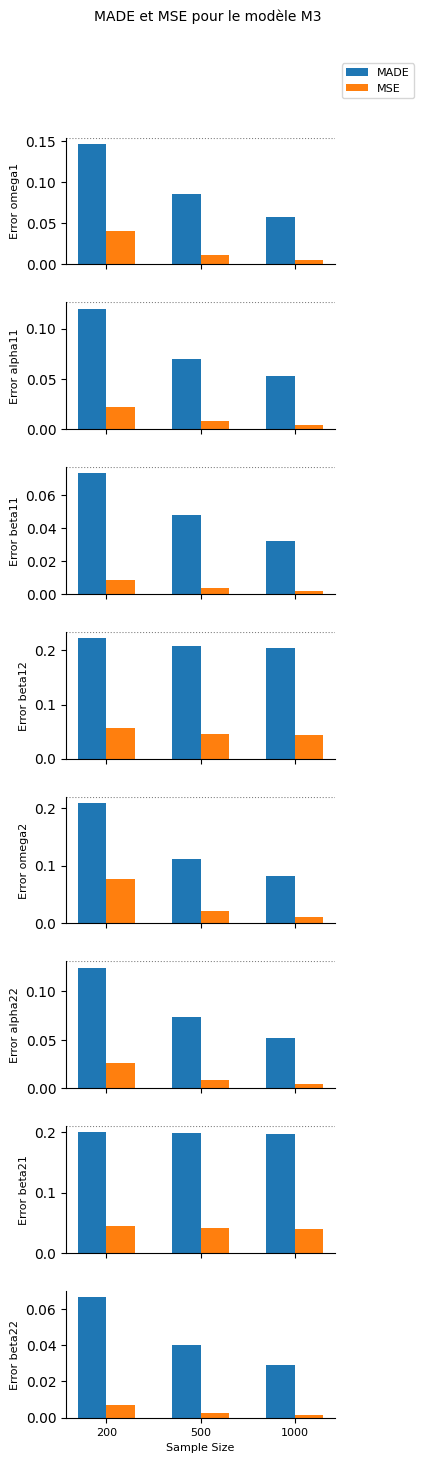

In [173]:
# Plotting

model ='M3'

num_params = len(errors[model]['MADE'][0])
fig, axes = plt.subplots(num_params, 1, figsize=(4.25, 2 * num_params), sharex=True)
fig.suptitle(f"MADE et MSE pour le modèle {model}", fontsize=10)

bar_width = 0.3 

# Create the legend handles and labels only once
handles = []
labels = []
for p in range(num_params):
    ax = axes[p]
    made_values = [errors[model]['MADE'][s][p] for s in range(len(sizes))]
    mse_values = [errors[model]['MSE'][s][p] for s in range(len(sizes))]

    bar1 = ax.bar(np.arange(len(sizes)), made_values, bar_width, label='MADE')
    bar2 = ax.bar(np.arange(len(sizes)) + bar_width, mse_values, bar_width, label='MSE')

    ax.set_xticks(np.arange(len(sizes)) + bar_width / 2)

    # Only set x-axis label for the bottom subplot
    if p == num_params - 1:
        ax.set_xticklabels(sizes, fontsize=8)
        ax.set_xlabel("Sample Size", fontsize=8) 
    else:
        ax.set_xticklabels([]) # Remove x-tick labels for other subplots
    # Define the parameter names you want to use for titles
    parameter_names = ["omega1", "alpha11", "beta11", "beta12", "omega2", "alpha22", "beta21", "beta22"]
    ax.set_ylabel(f"Error {parameter_names[p]}", fontsize=8)

    # Remove spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add horizontal dotted line separator (optional)
    if p < num_params - 1:
        ax.axhline(ax.get_ylim()[1], color='gray', linestyle='dotted', linewidth=0.8)

    # Collect handles and labels for the legend (only once)
    if p == 0:
        handles.append(bar1)
        handles.append(bar2)
        labels.append('MADE')
        labels.append('MSE')

# Place the legend outside the plot
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 0.95), fontsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.90, bottom=0.1, hspace=0.3, right=0.8)  # Adjust right for legend
plt.show()

In [171]:
# Assuming models and base_folder are defined
biais_dict = {model: {'biais': []} for model in models}
for model in models:
    for size in sizes:
        size_folder = os.path.join(base_folder, f"size_{size}")
        filename = f"estimstat_{model}_{size}.csv"
        filepath = os.path.join(size_folder, filename)

        if not os.path.exists(filepath):
            print(f"File {filepath} not found, skipping...")
            continue

        # Load the statistics DataFrame
        estimstat_filename = f"estimstat_{model}_{size}.csv"
        estimstat_filepath = os.path.join(size_folder, estimstat_filename)
        
        if not os.path.exists(estimstat_filepath):
            print(f"File {estimstat_filepath} not found, skipping...")
            continue

        estimstat_df = pd.read_csv(estimstat_filepath)

        # Access the 'Real Value' column as a NumPy array
        real_par = estimstat_df['Real Value'].values
        print(f"Real parameters: {real_par}")
        
        mean = estimstat_df['Mean'].values
        print(f"Mean: {mean}")

        biais_values = np.zeros(len(real_par))
        
        for i in range(len(real_par)):
            biais_values[i] = mean[i] - real_par[i]
            
        # Add to biais_dict dictionary
        biais_dict[model]['biais'].append(biais_values)

        # Save biais error
        biaisname = f"biais_{model}_{size}.csv"
        biaispath = os.path.join(size_folder, biaisname)
        np.savetxt(biaispath, biais_values, delimiter=',')
        print(f"Saved Biais for model {model} with size {size} to {biaispath}")

Real parameters: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
Mean: [0.39425425 0.15595923 0.48860549 0.3229426  0.62037659 0.35570919
 0.09996034 0.18284129]
Saved Biais for model M3 with size 200 to replications1/M3\size_200\biais_M3_200.csv
Real parameters: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
Mean: [0.336704   0.18563042 0.48895668 0.30743331 0.54378985 0.37964338
 0.10132651 0.19940763]
Saved Biais for model M3 with size 500 to replications1/M3\size_500\biais_M3_500.csv
Real parameters: [0.3 0.2 0.5 0.1 0.5 0.4 0.3 0.2]
Mean: [0.32143712 0.18525463 0.49829449 0.3041565  0.53188346 0.38891954
 0.10232237 0.19724149]
Saved Biais for model M3 with size 1000 to replications1/M3\size_1000\biais_M3_1000.csv


In [172]:
# Now create a new CSV file for each model containing the compiled bias values for all sizes
for model in models:
    model_biais = biais_dict[model]['biais']
    biais_df = pd.DataFrame(model_biais, index=[f"size_{size}" for size in sizes], columns=[f"Biais_{i}" for i in range(len(model_biais[0]))])
    
    compiled_biais_filepath = os.path.join(base_folder, f'compiled_biais_{model}.csv')
    biais_df.to_csv(compiled_biais_filepath, index_label='Size')
    print(f"Compiled biais saved to {compiled_biais_filepath} for model {model}")

Compiled biais saved to replications1/M3\compiled_biais_M3.csv for model M3
